In [4]:
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import infofile
import numpy as np
import mplhep as hep

In [5]:
lumi = 10#fb^-1
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [6]:
# Files can be downloaded from this webpage and should be placed in the same directory as the webpage
#https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/MC/


# we start with two files: top quark pair simulation, and real data, others can be added later
files = [#"mc_361108.Ztautau.2lep.root",
#          "mc_410011.single_top_tchan.2lep.root",
#          "mc_410012.single_antitop_tchan.2lep.root",
#          "mc_410013.single_top_wtchan.2lep.root",
#          "mc_410014.single_antitop_wtchan.2lep.root",
#          "mc_410155.ttW.2lep.root",
          "mc_410000.ttbar_lep.2lep.root",
          "data.2lep.root"
          ]

samples = ["tt"]
#samples = ["Z tau tau", "t", "tbar", "tW", "tbarW", "ttW", "tt"]

In [7]:
plot_mll = []
bins_mll = np.linspace(0, 400, num=46)

sample_names = []

btagWP77 = 0.6459

for file in files:
    sample_name = file.split(".")[1] 
    sample_names.append(sample_name)
    tree = uproot.open(file)["mini"]

    mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON, scaleFactor_LepTRIGGER, scaleFactor_BTAG, lep_type, lep_pt, lep_eta, lep_phi, lep_E, lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, jet_MV2c10 = tree.arrays(["mcWeight", "SumWeights", "XSection","trigM", "trigE","scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON","scaleFactor_LepTRIGGER","scaleFactor_BTAG", "lep_type","lep_pt", "lep_eta","lep_phi", "lep_E", "lep_charge", "lep_etcone20", "lep_ptcone30", "jet_n", "jet_pt", "jet_eta", "jet_phi","jet_E", "jet_MV2c10"], outputtype=tuple)
    print("File has been successfully opened!")
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    sum_lep_type = lep_type.sum()
    
    jetlv = LVepm.TLorentzVectorArray.from_ptetaphi(jet_pt, jet_eta, jet_phi, jet_E)
    jetlv = jetlv[jet_MV2c10.argsort()]    
    tags = jet_pt[jet_MV2c10 > btagWP77]

    #defining criteria around the singature of top quark pairp prouction with dileptonic decays: two isolated leptons and two b-jets
    trig_cut = ( (trigM==1) | (trigE==1))
    lep_kinematics_cut  = ( (lep_pt.max() > 25000) & (lep_pt.min() > 25000) & (lep_eta.min() >-2.1) & (lep_eta.max() < 2.1))
    lep_type_cut  = (sum_lep_type == 24)
    lep_iso_cut =  ((lep_reliso_pt.max() < 0.1) & (lep_reliso_et.max() < 0.1))
    lept_count_cut = (leplv.counts ==2)
    lept_charge_cut = (lep_charge.sum()==0)
    ntag_cut = (tags.counts>1)
    
    #combining the criteria into a single boolean for each event
    event_cut = ( lep_kinematics_cut  & lep_iso_cut  & lept_count_cut & lept_charge_cut & lep_type_cut & ntag_cut)

    first_lep_p4 =  leplv[event_cut,0]
    second_lep_p4 = leplv[event_cut,1]
    ll_p4 = first_lep_p4 + second_lep_p4 

    #making an array of event weights so the histograms will be normalised properly 
    mcWeight = mcWeight[event_cut] 
        
    if(file.split("_")[0] == "mc"):
        finalWeight = get_xsec_weight(sample_name)*(mcWeight)
    else:
        finalWeight = np.ones(len(mcWeight)) 
    
    H_mll, b = np.histogram(ll_p4.mass/1000.0, weights=np.full(len(ll_p4.mass),finalWeight), bins=bins_mll) # /1000.0 to change units to GeV
    plot_mll.append(H_mll)    

File has been successfully opened!
File has been successfully opened!


Text(1, 0, 'm$_{ll}$ [GeV]')

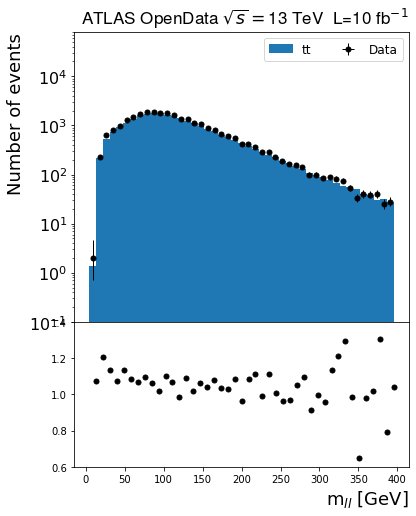

In [8]:
# Make the plot to compare histograms of data with the expectation from simulation

fig = plt.figure(figsize=(6, 8))
fig.tight_layout()

spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1], hspace=0.0)
ax0 = fig.add_subplot(spec[0])

total_mc = hep.histplot(plot_mll[:-1], bins=bins_mll, stack=True, label=samples, histtype='fill')
data = hep.histplot(plot_mll[len(plot_mll)-1], bins=bins_mll, stack=False, yerr=True, histtype="errorbar", color="black",label="Data")

hep.cms.lumitext(text=r'ATLAS OpenData $\sqrt{s}=$13 TeV  L=10 fb$^{-1}$', ax=None, fontname=None, fontsize=18)
plt.legend(loc=1, ncol=2, fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("m$_{ll}$ [GeV]", loc="right", fontsize=18)
plt.ylabel("Number of events", loc="top", fontsize=18)
plt.ylim([0.1,80000])
plt.yscale("log")

ax1 = fig.add_subplot(spec[1])
ratio = (plot_mll[len(plot_mll)-1])/np.sum(plot_mll[:-1],0)
unc =  (np.sqrt( np.sum(plot_mll[:-1],0) ))/np.sum(plot_mll[:-1],0)
ratio_plot = hep.histplot(ratio, bins=bins_mll, stack=False, yerr=False, histtype="errorbar", color="black",label="Data/MC")
plt.ylim([0.6,1.4])
plt.xlabel("m$_{ll}$ [GeV]", loc="right", fontsize=18)